# Лабораторная работа

In [1]:
%%capture
!pip install torchmetrics

In [2]:
import numpy as np
import glob
import os
from tqdm import tqdm

import json
import cv2
import torchvision.transforms as transforms

import torch
from torch import nn
from torch.nn import functional as F
from sklearn import preprocessing
from sklearn import metrics
from torchmetrics.functional import char_error_rate

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
device

'cuda'

##Загрузка датасета с kaggle

In [4]:
%%capture
! pip install kaggle

In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download romanleo2003/labtinkoff

 99% 2.10G/2.13G [00:12<00:00, 148MB/s]
100% 2.13G/2.13G [00:12<00:00, 178MB/s]


In [10]:
%%capture
! unzip -O utf8 /content/labtinkoff.zip

## Подготовка данных

Получим все имена файлов и извлечём из них метки. 

In [11]:
data_path = "/content/CCPD2019-dl1/train"
img_fnames = glob.glob(os.path.join(data_path, "*.jpg"))
img_fnames = [img_fname.split('/')[-1] for img_fname in img_fnames]
# Формируем список с метками
img_labels = [img_fname.split('-')[-1][:-4] for img_fname in img_fnames]
# Из строки в список
img_labels = [[c for c in word] for word in img_labels]

In [12]:
print('Пример метки:', img_labels[0])

Пример метки: ['皖', 'A', 'N', '6', '3', '6', '0']


Закодируем все метки с помощью LabelEncoder:

In [15]:
img_labels_flat = [c for clist in img_labels for c in clist]

label_enc = preprocessing.LabelEncoder()
label_enc.fit(img_labels_flat)

img_labels_enc = [label_enc.transform(x) for x in img_labels]
img_labels_enc = np.array(img_labels_enc)
img_labels_enc = img_labels_enc + 1

In [16]:
print('Пример закодированной метки:', img_labels_enc[0])

Пример закодированной метки: [52 11 23  7  4  7  1]


Оформим вышеописанное в функцию:

In [35]:
def get_labels(data_path):
  img_fnames_full = glob.glob(os.path.join(data_path, "*.jpg"))
  img_fnames = [img_fname.split('/')[-1] for img_fname in img_fnames_full]
  img_labels = [img_fname.split('-')[-1][:-4] for img_fname in img_fnames]
  img_labels = [[c for c in word] for word in img_labels]
  img_labels_flat = [c for clist in img_labels for c in clist]

  img_labels_enc = [label_enc.transform(x) for x in img_labels]
  img_labels_enc = np.array(img_labels_enc)
  img_labels_enc = img_labels_enc + 1

  return img_fnames_full, img_labels_enc, img_labels

**Создадим класс датасета:**

Приведем все картинки к размеру 128х32 и сделаем их черно-белыми

In [19]:
class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, targets, transform=None):
        # resize = (height, width)
        self.image_paths = image_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        targets = self.targets[idx]
        img_fname = self.image_paths[idx]

        img = cv2.imread(img_fname)
        img = cv2.resize(img, (128, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if self.transform:
            img = self.transform(img)

        img = np.array(img)

        return {
            "images": torch.tensor(img, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

Используем следующие преобразования и аугментации:

In [20]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.RandomRotation(degrees=(-5, 5)),
     transforms.ToTensor(), 
     transforms.Normalize((0.8), (0.8))
     ])

Сформируем датасеты для обучающей и тестовой выборок:

In [36]:
train_imgs, train_targets, train_targets_orig = get_labels('/content/CCPD2019-dl1/train')
test_imgs, test_targets, test_targets_orig = get_labels('/content/CCPD2019-dl1/test')

In [37]:
train_dataset = ClassificationDataset(
        image_paths=train_imgs,
        targets=train_targets,
        transform=transform
    )

test_dataset = ClassificationDataset(
        image_paths=test_imgs,
        targets=test_targets,
        transform=transform
    )


In [38]:
print(f'train dataset содержит {len(train_dataset)} элементов')
print(f'test dataset содержит {len(test_dataset)} элементов')

train dataset содержит 199980 элементов
test dataset содержит 9999 элементов


Пример картинки после применения преобразований:

torch.Size([1, 32, 128])


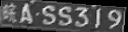

In [39]:
import torchvision.transforms as T

print(train_dataset[1]['images'].shape)
T.ToPILImage()(train_dataset[1]['images'])

In [40]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=2,
        shuffle=True,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32,
        num_workers=2,
        shuffle=False,
    )

## Созданиe модели

FCNN + Bidirectional GRU:
(на выходе используется CTCLoss)

In [41]:
class FCNN_BiGRU(nn.Module):
    def __init__(self, num_chars):
        super(FCNN_BiGRU, self).__init__()
        
        self.conv_1 = nn.Conv2d(1, 128, kernel_size=(3, 6), padding=(1, 1))
        self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3, 6), padding=(1, 1))
        self.pool_2 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv_3 = nn.Conv2d(64, 32, kernel_size=(3, 6), padding=(1, 1))
        self.pool_3 = nn.MaxPool2d(kernel_size=(2, 1))

        self.linear_1 = nn.Linear(128, 64)
        self.drop_1 = nn.Dropout(0.2)

        self.lstm = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars + 1)

    def forward(self, images, targets=None):
        bs, _, _, _ = images.size()
        x = F.relu(self.conv_1(images))
        x = self.pool_1(x)
        x = F.relu(self.conv_2(x))
        x = self.pool_2(x)
        x = F.relu(self.conv_3(x))
        x = self.pool_3(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)
        x = F.relu(self.linear_1(x))
        x = self.drop_1(x)
        x, _ = self.lstm(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(
                size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32
            )
            target_lengths = torch.full(
                size=(bs,), fill_value=targets.size(1), dtype=torch.int32
            )

            loss = nn.CTCLoss(blank=0)(
                log_probs, targets, input_lengths, target_lengths
            )
            return x, loss

        return x, None



In [42]:
from torchsummary import summary

model = FCNN_BiGRU(num_chars=len(label_enc.classes_))
model.to(device)
summary(model, (1, 32, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 128, 32, 125]           2,432
         MaxPool2d-2          [-1, 128, 16, 62]               0
            Conv2d-3           [-1, 64, 16, 59]         147,520
         MaxPool2d-4            [-1, 64, 8, 59]               0
            Conv2d-5            [-1, 32, 8, 56]          36,896
         MaxPool2d-6            [-1, 32, 4, 56]               0
            Linear-7               [-1, 56, 64]           8,256
           Dropout-8               [-1, 56, 64]               0
               GRU-9  [[-1, 56, 64], [-1, 2, 32]]               0
           Linear-10               [-1, 56, 67]           4,355
Total params: 199,459
Trainable params: 199,459
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 4.06
Params size (MB): 0.76
Estimated

## Обучение модели:

In [43]:
def train_fn(model, data_loader, optimizer):
    model.train()
    res_loss = 0
    tk0 = tqdm(data_loader, total=len(data_loader))
    for data in tk0:
        for key, value in data.items():
            data[key] = value.to(device)
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        res_loss += loss.item()
    return res_loss / len(data_loader)


def eval_fn(model, data_loader):
    model.eval()
    res_loss = 0
    res_preds = []
    tk0 = tqdm(data_loader, total=len(data_loader))
    for data in tk0:
        for key, value in data.items():
            data[key] = value.to(device)
        batch_preds, loss = model(**data)
        batch_preds = decode_predictions(batch_preds, label_enc)
        res_loss += loss.item()
        res_preds.extend(batch_preds)
    return res_preds, res_loss / len(data_loader)


In [44]:
from itertools import groupby

# Перевод tensor -> 'aaa---bb--c--dd' (длина строки = 56) -> 'abcd'
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    model_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                p = encoder.inverse_transform([k])[0]
                temp.append(p)
        # Получение из строки вида 'aaa----bb-ccc--d' строку вида 'abcd'
        tp = ''.join(temp)
        tp = ''.join(key for key, group in groupby(tp))
        tp = tp.replace("-", "")
        
        model_preds.append(tp)
    return model_preds


## Цикл обучения и подсчёт метрик:

In [45]:
model = FCNN_BiGRU(num_chars=len(label_enc.classes_))
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True)

epochs = 7

In [47]:
for epoch in range(epochs):
    train_loss = train_fn(model, train_loader, optimizer)
    valid_preds, test_loss = eval_fn(model, test_loader)
    test_targets_orig = [''.join(c) for c in test_targets_orig]

    accuracy = metrics.accuracy_score(test_targets_orig, valid_preds)
    cer = char_error_rate(preds=valid_preds, target=test_targets_orig)
    
    print(f"Epoch={epoch}, Train Loss={train_loss}, Test Loss={test_loss} Accuracy={accuracy} CER={cer}")
    scheduler.step(test_loss)

100%|██████████| 313/313 [00:13<00:00, 22.60it/s]


Epoch=0, Train Loss=0.3229073940669, Test Loss=0.0677269335520772 Accuracy=0.9027902790279028 CER=0.01683025434613228


100%|██████████| 313/313 [00:13<00:00, 22.44it/s]


Epoch=1, Train Loss=0.03282742394642904, Test Loss=0.0525172210842246 Accuracy=0.927992799279928 CER=0.012472676113247871


100%|██████████| 313/313 [00:14<00:00, 22.09it/s]


Epoch=2, Train Loss=0.021312667419193312, Test Loss=0.035915495590500224 Accuracy=0.9455945594559456 CER=0.00897232536226511


100%|██████████| 313/313 [00:14<00:00, 21.56it/s]


Epoch=3, Train Loss=0.016146220850562675, Test Loss=0.032312182216948204 Accuracy=0.9536953695369537 CER=0.007386452984064817


100%|██████████| 313/313 [00:14<00:00, 22.18it/s]


Epoch=4, Train Loss=0.013307490112364758, Test Loss=0.02997821529055373 Accuracy=0.9564956495649565 CER=0.007072135806083679


100%|██████████| 313/313 [00:14<00:00, 21.84it/s]


Epoch=5, Train Loss=0.011072458351447713, Test Loss=0.02531285770911576 Accuracy=0.9615961596159616 CER=0.006072035990655422


100%|██████████| 313/313 [00:16<00:00, 18.85it/s]


Epoch=6, Train Loss=0.009269853770867921, Test Loss=0.02417460887094706 Accuracy=0.9625962596259626 CER=0.006043461617082357


## Финальные метрики:

In [55]:
print(f'Accuracy: {round(accuracy*100, 2)}%')
print(f'CER     : {round(cer.item() * 100, 2)}%')


Accuracy: 96.26%
CER     : 0.6%


## Анализ ошибок модели:

Составим словарь с CER для каждой картинки и отсортируем его. 

In [63]:
cer_dict = {}
for i in range(len(test_dataset)):
  cer = char_error_rate(preds=valid_preds[i], target=test_targets_orig[i]) 
  cer_dict[i] = cer.item()
cer_dict = {k: v for k, v in reversed(sorted(cer_dict.items(), key=lambda item: item[1]))}

Отберём топ-10 худших предсказаний по CER:

In [102]:
from PIL import Image

paths = []
titles = []
counter = 0

for k, v in cer_dict.items():
  paths.append(test_dataset.image_paths[k])
  title = f'true: {test_targets_orig[k]} \n pred: {valid_preds[k]}'
  titles.append(title)
  counter += 1

  if counter == 10:
    break
  
images = [Image.open(u)for u in paths]

Посмотрим на эти 10 картинок:

In [124]:
# Отображение картинок в удобном виде
import matplotlib.pyplot as plt
import textwrap

def display_images(images, titles, columns=2, width=10, height=4, label_wrap_length=20, label_font_size=20):

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))

    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)
        title = titles[i]
        title=textwrap.wrap(title, label_wrap_length)
        title="\n".join(title)
        plt.title(title, fontsize=label_font_size); 

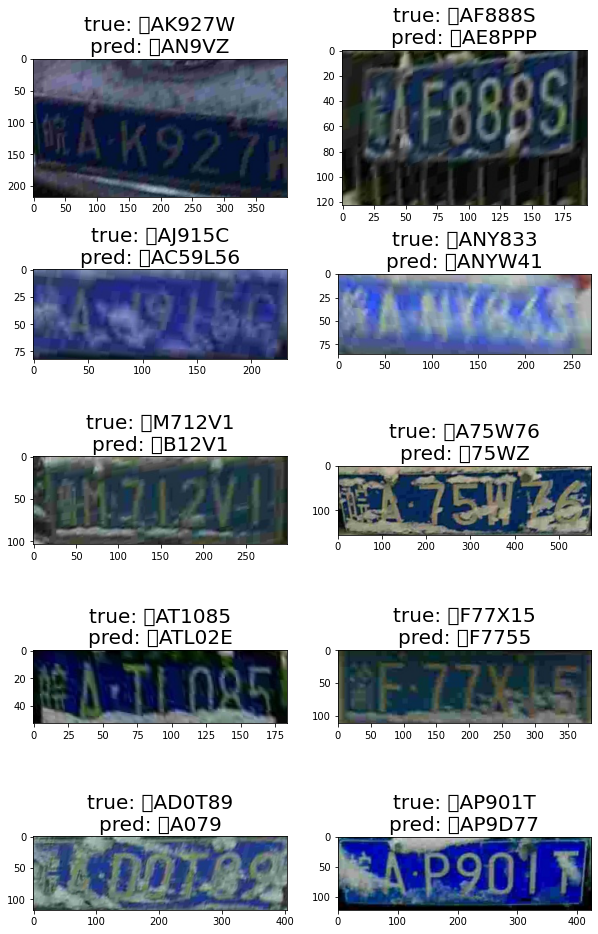

In [125]:
display_images(images, titles)

По этим 10 картинкам можно понять, что главными причинами плохих результатов модели на этих примерах являются:
1. Плохое качество картинки
2. Сильная занесённость номеров снегом
3. Угол, под которым сделана фотография (сильнее всего влияет на иероглифы, так как их структура сложнее)

То есть в датасете имеются картинки, на которых даже человек не распознает номера.

Однако, эти 10 картинок показали, что модели точно есть куда стремится (она ошибается и на простых примерах) Иногда она принимает снег за часть символа, хотя их цвета немного отличаются.

Предложения по улучшению распознавания:
1. Обучить отдельную модель на иероглифах
2. В качестве аугментаций добавлять шум (иммитировать снег)
3. Усложнить архитектуру действующей модели
4. Подавать на вход модели тензор большей размерности (картинку с лучшим разрешением). Я подавал 128х32 для ускорения процесса обучения.

